In [1]:
import pandas, pickle, os
import numpy as np
from matplotlib import pyplot as plt

#ridge regression
from sklearn.metrics import r2_score
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import GroupKFold

from torch import Tensor
from torchvision.models import feature_extraction
from torch.utils.data import DataLoader

import encoding_utils as eu
import models_class as mc
import visualisation_utils as visu
import seaborn as sns

In [2]:
#-----------env args------------------------------------------------------------
dataset = 'mutemusic'
sub = 'sub-03'
no_init = False
tr=1.49

#absolute paths
model_path = '/home/maellef/Results/best_models/converted' 
training_data_path = '/home/maellef/git/MuteMusic_analysis/data/training_data'

#specific to soundnet/audio
model_type = 'soundnet'#'conv4'
resolution = 'MIST_ROI'# 'auditory_Voxels' 
sr=22050

#specific to one instance
stim_tracks = 'silenced'
category = 'all'
repetition = 'all'
original_sr = 48000

#visualisation
r2_max_threshold = 1

In [3]:
#------------load training data-------------------------------------------------------
#load data + metadata
metadata_path = os.path.join(training_data_path, f'{dataset}_{sub}_{stim_tracks}_metadata.tsv')
pairbold_path = os.path.join(training_data_path, f'{dataset}_{sub}_{stim_tracks}_pairWavBold')

data_df = pandas.read_csv(metadata_path, sep='\t')
with open(pairbold_path, 'rb') as f: 
    wavbold = pickle.load(f)

#data selection
i_selection = eu.select_df_index(data_df, category=category, repetition=repetition)
print(i_selection)
selected_wavbold = [(wav, bold) for i, (wav, bold) in enumerate(wavbold) if i in i_selection]

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179]


In [4]:
#extract X and Y data for prediction + check for empty data (WIP: move to previous later)
empty_pair = []
for i, (wav, bold) in enumerate(selected_wavbold):
    if wav.shape[0] == 0 and bold.shape[0] == 0:
        empty_pair.append(i)

selected_wavbold = [(wav, bold) for (wav, bold) in selected_wavbold if wav.shape[0] != 0]
print(f'empty pair: {empty_pair}')
correct_data_df = data_df.drop(empty_pair).reset_index()
correct_data_df.drop(['index', 'Unnamed: 0'], axis='columns', inplace=True)

empty pair: []


In [5]:
#----------load model + convert to extract embedding-------------------------------------
#load model (specific to soundnet model)
print(sub, resolution, model_type, category)
model_name, model = eu.load_sub_model(sub, resolution, model_type, model_path, no_init=False)
print(model_name)
i = model_name.find('conv_') + len('conv_')
temporal_size = int(model_name[i:i+3])

#create model with extractable embeddings
return_nodes = {'soundnet.conv7.2':'conv7', 'encoding_fmri':'encoding_conv'}
model_feat = feature_extraction.create_feature_extractor(model, return_nodes=return_nodes)

sub-03 MIST_ROI soundnet all
shape of encoding matrice from last encoding layer : 1024 X 210
sub-03_friends_MIST_ROI_SoundNetEncoding_conv_0700515_0e+00_1e-04_1e-03_opt110_wbid2mlgalkf_20220407-095244.pt


In [6]:
#create dataset
encoding_dataset = mc.soundnet_dataset(selected_wavbold, tr=tr, sr=sr)
if original_sr != encoding_dataset.sr:
    encoding_dataset.resample_input(input_sr=original_sr)
encoding_dataset.convert_input_to_tensor()

In [7]:
#for training : criterion=nn.MSELoss(reduction='sum')
testloader = DataLoader(encoding_dataset)
out_p = eu.test(testloader, net=model_feat, return_nodes=return_nodes, gpu=False)

In [8]:
Y_pred_converted, Y_real_converted = [], []
for y_p, y_r in out_p['conv7']:
    (y_p_converted, y_r_converted) = encoding_dataset.redimension_output(y_p, y_r, cut='end')
    Y_pred_converted.append(y_p_converted)
    Y_real_converted.append(y_r_converted)
print(len(Y_pred_converted))

180


In [9]:
#specific to mutemusic---------separate silence bold from music bold
def separate_silence_from_music(track_data, metadata_df):
    music_segments, silence_segments = [],[]
    for track, (i, metadata) in zip(track_data, metadata_df.iterrows()):
        timestamps_s = {'duration':[metadata['S1_duration'], metadata['S2_duration'], metadata['S3_duration'], metadata['S4_duration']],
                        'start':[metadata['S1_start'], metadata['S2_start'], metadata['S3_start'], metadata['S4_start']],
                        'stop':[metadata['S1_stop'], metadata['S2_stop'], metadata['S3_stop'], metadata['S4_stop']]}
        siltt_df = pandas.DataFrame(timestamps_s).sort_values(by='start').dropna()
        
        music_start = 0
        for i, silence_tt in siltt_df.iterrows():
            silence_start = round(silence_tt['start']/tr)
            music_stop = silence_start
            silence_stop = round(silence_tt['stop']/tr)

            music_segments.append(track[music_start:music_stop])
            silence_segments.append(track[silence_start:silence_stop])
            music_start = silence_stop
            
        music_segments.append(track[music_start:len(track)])
        
    return music_segments, silence_segments

In [10]:
#create train/test for ridge regression

train_i_selection = eu.select_df_index(data_df, repetition=[1,2])
train_data = [(embedding, real) for i, (embedding, real) 
              in enumerate(zip(Y_pred_converted, Y_real_converted)) if i in train_i_selection]
test_i_selection = eu.select_df_index(data_df, repetition=[3])
test_data = [(embedding, real) for i, (embedding, real) 
             in enumerate(zip(Y_pred_converted, Y_real_converted)) if i in test_i_selection]

train_data_df = data_df.iloc[train_i_selection]
test_data_df = data_df.iloc[test_i_selection]

fam_i_selection = eu.select_df_index(data_df, groupe='F', repetition=3)
test_Fdata = [(embedding, real) for i, (embedding, real) 
              in enumerate(zip(Y_pred_converted, Y_real_converted)) if i in fam_i_selection]
ufam_i_selection = eu.select_df_index(data_df, groupe='U', repetition=3)
test_Udata = [(embedding, real) for i, (embedding, real) 
              in enumerate(zip(Y_pred_converted, Y_real_converted)) if i in ufam_i_selection]


test_Fdata_df = data_df.iloc[fam_i_selection]
test_Udata_df = data_df.iloc[ufam_i_selection]

In [11]:
#for (x, y), (i, row)  in zip(train_data, train_data_df.iterrows()):
#    print(i, x.shape, y.shape, row.tr_duration)

#train------------------------------
embedding_x = [x for x, y in train_data]
full_x = np.vstack(embedding_x) 
mus_x, sil_x = separate_silence_from_music(embedding_x, train_data_df)
mus_x = np.vstack(mus_x)
sil_x = np.vstack(sil_x)

bold_y = [y for x, y in train_data]
full_y = np.vstack(bold_y) 
mus_y, sil_y = separate_silence_from_music(bold_y, train_data_df)
mus_y = np.vstack(mus_y)
sil_y = np.vstack(sil_y)


In [12]:
alphas = np.logspace(0.1, 3, 10)
model = RidgeCV(
        alphas=alphas,
        fit_intercept=True,
        cv=10)

model.fit(mus_x, mus_y)

RidgeCV(alphas=array([   1.25892541,    2.64376119,    5.55193591,   11.65914401,
         24.48436747,   51.41751828,  107.97751623,  226.75431259,
        476.1872663 , 1000.        ]),
        cv=10)

In [13]:
#test-no select------------------------------
test_embedding_x = [x for x, y in test_data]
test_full_x = np.vstack(test_embedding_x) 
test_mus_x, test_sil_x = separate_silence_from_music(test_embedding_x, test_data_df)
test_mus_x = np.vstack(test_mus_x)
test_sil_x = np.vstack(test_sil_x)

test_bold_y = [y for x, y in test_data]
test_full_y = np.vstack(test_bold_y) 
test_mus_y, test_sil_y = separate_silence_from_music(test_bold_y, test_data_df)
test_mus_y = np.vstack(test_mus_y)
test_sil_y = np.vstack(test_sil_y)

In [ ]:
#test-select familiar/Unfamiliar------------------------------
fam_i_selection = eu.select_df_index(data_df, groupe='F', repetition=3)
ufam_i_selection = eu.select_df_index(data_df, groupe='U', repetition=3)

test_Fdata = [(embedding, real) for i, (embedding, real) 
              in enumerate(zip(Y_pred_converted, Y_real_converted)) if i in fam_i_selection]
test_Udata = [(embedding, real) for i, (embedding, real) 
              in enumerate(zip(Y_pred_converted, Y_real_converted)) if i in ufam_i_selection]
test_Fdata_df = data_df.iloc[fam_i_selection]
test_Udata_df = data_df.iloc[ufam_i_selection]

test_embedding_x = [x for x, y in test_Fdata]
test_full_x = np.vstack(test_embedding_x) 
test_mus_x, test_sil_x = separate_silence_from_music(test_embedding_x, test_Fdata_df)
test_mus_x = np.vstack(test_mus_x)
test_sil_x = np.vstack(test_sil_x)

test_bold_y = [y for x, y in test_Fdata]
test_full_y = np.vstack(test_bold_y) 
test_mus_y, test_sil_y = separate_silence_from_music(test_bold_y, test_Fdata_df)
test_mus_y = np.vstack(test_mus_y)
test_sil_y = np.vstack(test_sil_y)

In [14]:
#checkup----------------------------
print(full_x.shape, mus_x.shape, sil_x.shape)
print(full_y.shape, mus_y.shape, sil_y.shape)
print(test_full_x.shape, test_mus_x.shape, test_sil_x.shape)
print(test_full_y.shape, test_mus_y.shape, test_sil_y.shape)

(4370, 1024) (3296, 1024) (1074, 1024)
(4370, 210) (3296, 210) (1074, 210)
(2185, 1024) (1648, 1024) (537, 1024)
(2185, 210) (1648, 210) (537, 210)


0.11285463941580232


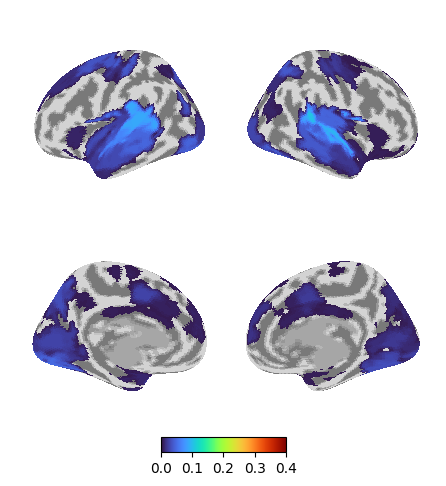

In [17]:
y_p = model.predict(test_mus_x)
r2 = r2_score(test_mus_y, y_p, multioutput='raw_values')
r2 = np.where(r2<0, 0, r2)
print(max(r2))
colormap = visu.extend_colormap(original_colormap='turbo',
                          percent_start = 0.1, percent_finish=0)
visu.surface_fig(r2, vmax=0.4, threshold=0.005, cmap='turbo', symmetric_cbar=False)

savepath = f'./figures/{sub}_{dataset}_{model_type}_mus_predict_mus_HRF2.png'
plt.savefig(savepath)

other analyses

In [ ]:
#test-no select------------------------------
test_embedding_x = [x for x, y in test_data]
test_mus_x, test_sil_x = separate_silence_from_music(test_embedding_x, test_data_df)

test_bold_y = [y for x, y in test_data]
test_mus_y, test_sil_y = separate_silence_from_music(test_bold_y, test_data_df)

#test-Fam vs unfam-----------------------------------------------------------------
test_fembedding_x = [x for x, y in test_Fdata]
test_fmus_x, test_fsil_x = separate_silence_from_music(test_fembedding_x, test_Fdata_df)

test_fbold_y = [y for x, y in test_Fdata]
test_fmus_y, test_fsil_y = separate_silence_from_music(test_fbold_y, test_Fdata_df)

In [ ]:
test_x = test_fsil_x
test_y = test_fsil_y

all_r2 = np.array([]).reshape(-1, 210)
for x, y in zip(test_x, test_y):
    if len(y)>1:
        y_p = model.predict(x)
        segment_r2 = r2_score(y, y_p, multioutput='raw_values')
        all_r2 = np.concatenate([all_r2, segment_r2.reshape(-1, 210)], axis=0)
        #print(np.max(segment_r2), np.argmax(segment_r2))

r2 = np.median(all_r2, axis=0)
print(all_r2.shape, r2.shape, np.max(r2))

In [ ]:
all_yp = np.vstack(Y_pred_converted)
all_yr = np.vstack(Y_real_converted)
print(all_yp.shape, all_yr.shape)

sil_yp = np.vstack(sil_yp)
sil_yr = np.vstack(sil_yr)
print(sil_yp.shape, sil_yr.shape)

mus_yp = np.vstack(mus_yp)
mus_yr = np.vstack(mus_yr)
print(mus_yp.shape, mus_yr.shape)

real_y = all_yr
predicted_y = all_yp

r2 = r2_score(real_y, predicted_y, multioutput='raw_values')
#r2 = np.where(r2<0, 0, r2)
print(max(r2))
colormap = visu.extend_colormap(original_colormap='turbo',
                          percent_start = 0.1, percent_finish=0)
visu.surface_fig(r2, vmax=r2_max_threshold, threshold=0.00005, cmap='turbo', symmetric_cbar=False)

savepath = f'./figures/{sub}_generalisation_{model_type}_{dataset}_{category}_fulltrack.png'
plt.savefig(savepath)

In [ ]:
title, category, groupe, r2_max, imax = [], [], [], [], []
r2_by_roi = []
for y_p, y_r, i in zip(Y_pred_converted, Y_real_converted, i_selection):
    title.append(data_df.iloc[i].title)
    track_duration = data_df.iloc[i].tr_duration
    category.append(data_df.iloc[i].category)
    groupe.append(data_df.iloc[i].groupe)

    r2_track = r2_score(y_r, y_p, multioutput='raw_values')
    r2_max.append(np.max(r2_track))
    imax.append(np.argmax(r2_track))
    r2_by_roi.append(r2_track)
    
tracks_r2_df = pandas.DataFrame({
    'title':title,
    'category':category,
    'groupe':groupe,
    'r2_max':r2_max,
    'imax':imax
})
print(len(tracks_r2_df))
a = tracks_r2_df['imax'].value_counts()

MIST_labels = pandas.read_csv('/home/maellef/DataBase/fMRI_parcellations/MIST_parcellation/Parcel_Information/MIST_ROI.csv', sep=';')
labels = []
for i in a.index.values:
    lab = MIST_labels['label'].iloc[i]
    labels.append(lab)
a = a.to_frame()
a['labels']=labels
a = a.reset_index().rename(columns={"imax":"imax"})		
pandas.set_option('display.max_rows', None)
print(a)

tracks_labels = [a['labels'].loc[a['imax']==i].values[0] for i in tracks_r2_df['imax']]
tracks_r2_df['labels']=tracks_labels

tracks_r2_df.loc[tracks_r2_df['labels']=='R_STgyr_m'].sort_values(by=['category', 'title'])

In [ ]:
g = sns.catplot(
    data=tracks_r2_df, x="r2_max", y="title", col="category", hue='groupe',
    kind="strip", dodge = True, height=10
)
g.set(xlim=(-0.1, 0.55))
for ax in g.axes.flat:
    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

savepath = f'./figures/{sub}_generalisation_per_track_{model_type}_{dataset}.png'
plt.savefig(savepath)